In [2]:
import gymnasium as gym

from stable_baselines3 import SAC, DDPG, PPO

from environment import *
from env_wrappers import *
from matplotlib import pyplot as plt
from general_utils import *
from delay_model import *
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import torch
from wc_sac import *
from stable_baselines3.common.logger import Logger, configure
import datetime
import copy
from test_utils import *
from train_utils import *
from orchestrator import *
import pandas as pd
from safe_sac import SafeSAC

%load_ext autoreload
%autoreload 2 

plt.rcParams['font.family'] = 'serif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plot training

### Undelayed agents

In [22]:
env_dates_dict = {
    'LinearVelocity' : ['0614','0614','0614'], 
    'NonLinearVelocity' : ['0614','0614','0615'], 
    'Position' : ['0615','0615','0615'], 
    'RobotSteer' : ['0619','0619','0619'],
    'SphericalTank' : ['0626','0626','0626']
}

setpoints = [2.6141, 2.6142, 2.6143]
env_setpoint_dict = {
    'LinearVelocity' : setpoints, 
    'NonLinearVelocity' : setpoints, 
    'Position' : [[0.0, setpoint] for setpoint in setpoints], 
    'RobotSteer' :[[setpoint, setpoint] for setpoint in [2.6181, 2.6182, 2.6183]],
    'SphericalTank' : [2.6261, 2.6262, 2.6263]
}


print(f"Setpoint dict {env_setpoint_dict}")

agent_types = ['sac']
agent_official_names = {
    'sac' : 'SAC (no delay)',
    'wcsac' : 'AQ-SAC',
    'wcsacmin' : 'MAQ-SAC',
    'safesac' : 'DQ-SAC',
    'safesacmin' : 'MDQ-SAC',
    'augsacsafe' : 'DRSAC'

}

env_names = env_dates_dict.keys()

env_dict = {}
for env_name in env_names:
    agent_dict = {}
    dates = env_dates_dict[env_name]
    for agent_type in agent_types:
        run_arr = []
        for i in range(len(setpoints)) : 
            df = pd.read_csv(f'logs\\train\\{env_name}\\setpoint-error\\randomised\\{dates[i]}\\Desired{env_setpoint_dict[env_name][i]}\\{agent_type}\\progress.csv')
            run_arr.append(np.array(df['rollout/ep_rew_mean']))

        min_len = min([len(run_arr[k]) for k in range(len(run_arr))])
        run_arr = [run_arr[k][:50 if len(run_arr[k]) - 50 < 10 else len(run_arr[k])] for k in range(len(run_arr))]
        agent_dict[agent_type] = run_arr

    env_dict[env_name] = agent_dict


Setpoint dict {'LinearVelocity': [2.6141, 2.6142, 2.6143], 'NonLinearVelocity': [2.6141, 2.6142, 2.6143], 'Position': [[0.0, 2.6141], [0.0, 2.6142], [0.0, 2.6143]], 'RobotSteer': [[2.6181, 2.6181], [2.6182, 2.6182], [2.6183, 2.6183]], 'SphericalTank': [2.6261, 2.6262, 2.6263]}


Data for LinearVelocity and sac, data with len [50, 50, 50]
Data for NonLinearVelocity and sac, data with len [50, 50, 50]
Data for Position and sac, data with len [50, 50, 50]
Data for RobotSteer and sac, data with len [100, 100, 100]
Data for SphericalTank and sac, data with len [50, 50, 50]


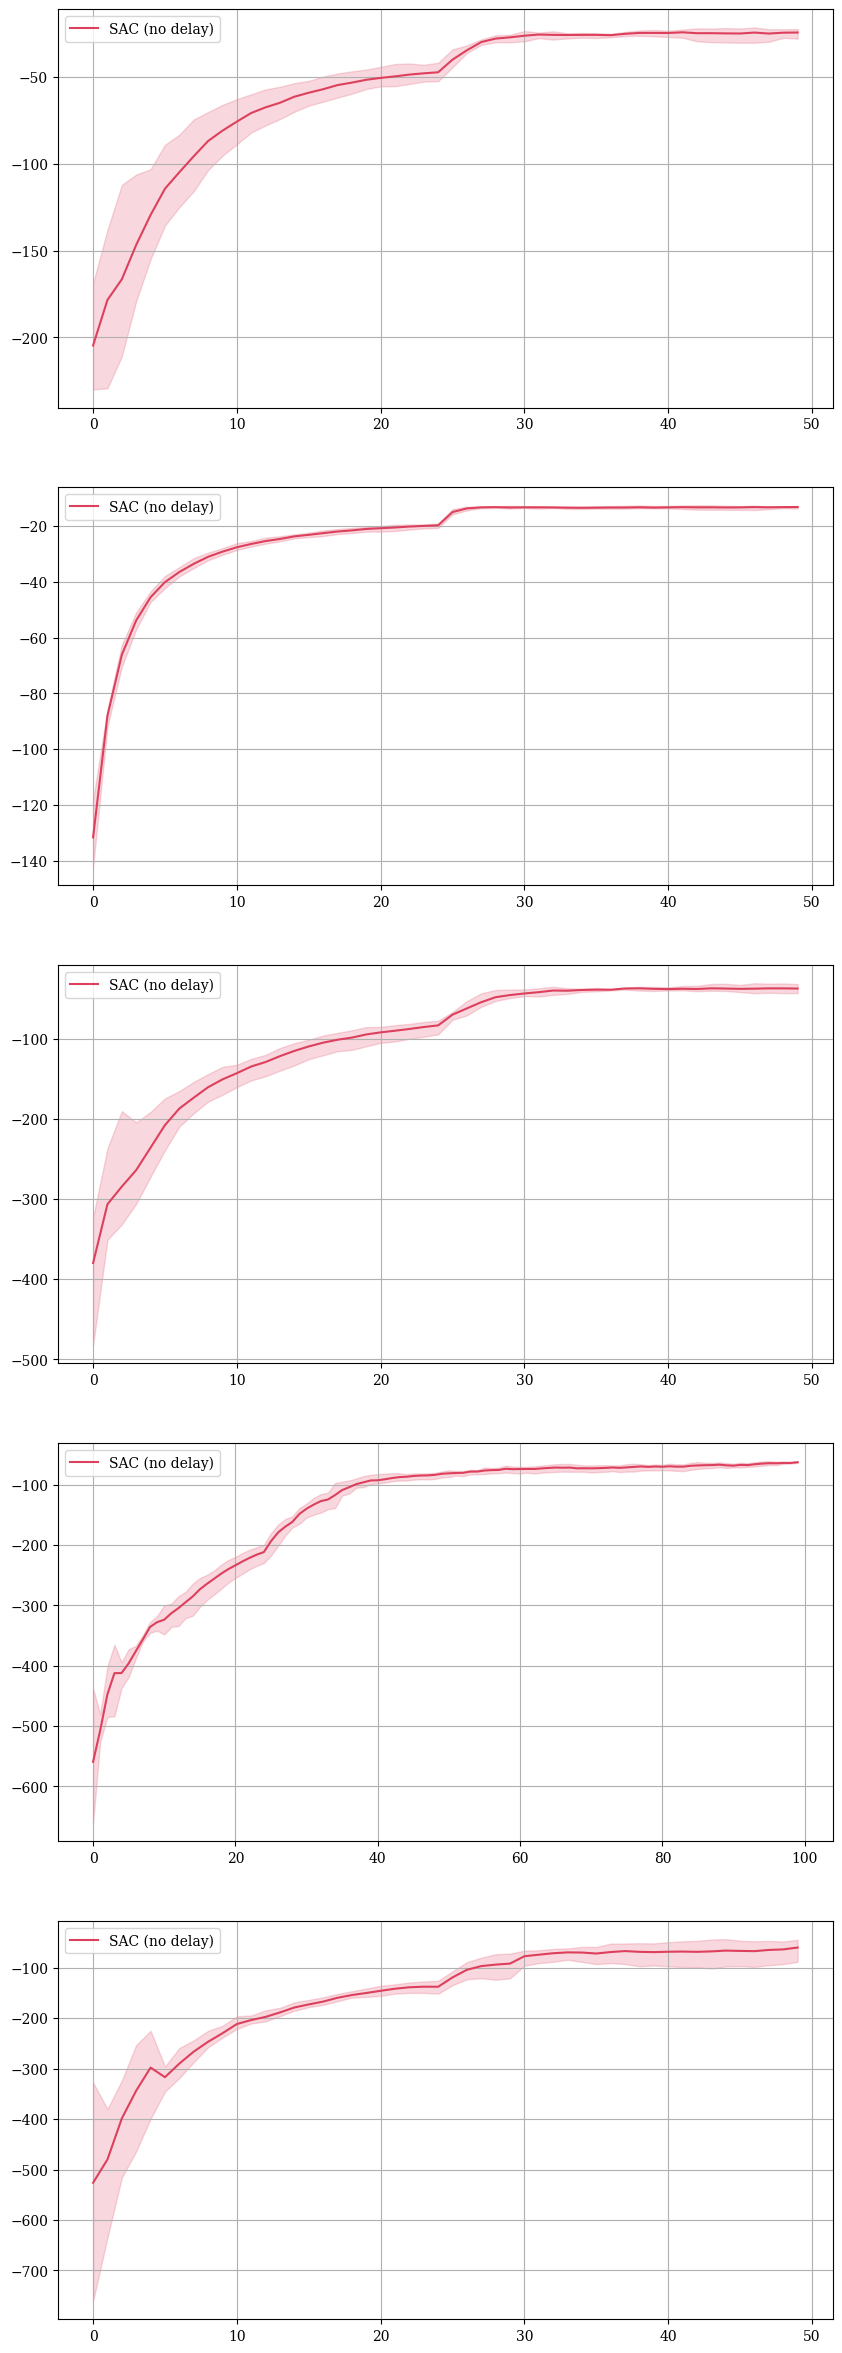

In [4]:
colors = ['cold_red', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']

f, ax = plt.subplots(len(env_names),1, figsize = (10,30))
for e, env_name in enumerate(env_names):
    for i, agent_type in enumerate(agent_types) : 
        print(f"Data for {env_name} and {agent_type}, data with len {[len(env_dict[env_name][agent_type][k]) for k in range(3) ]}")
        res = np.array(env_dict[env_name][agent_type])
        
        r_min = np.min(res, axis = 0)
        r_max = np.max(res, axis = 0)
        r_avg= np.mean(res, axis = 0)

        ax[e].plot(range(len(r_avg)), r_avg, color = global_config.COLORS[colors[i]])
        ax[e].fill_between(range(len(r_avg)), r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .2, label='_nolegend_')
# ax.legend([agent_types[i//2] if i%2 == 0 else '' for i in range(2*len(agent_types))]
    ax[e].legend([agent_official_names[agent_types[i]] for i in range(len(agent_types))])
    ax[e].grid()
    ax[e].set_tile = env_name

Plotting env LinearVelocity with 0 and (0, 0)
Data for LinearVelocity and sac, data with len [50, 50, 50]
Plotting env NonLinearVelocity with 1 and (1, 0)
Data for NonLinearVelocity and sac, data with len [50, 50, 50]
Plotting env Position with 2 and (0, 0)
Data for Position and sac, data with len [50, 50, 50]
Plotting env RobotSteer with 3 and (1, 0)
Data for RobotSteer and sac, data with len [100, 100, 100]


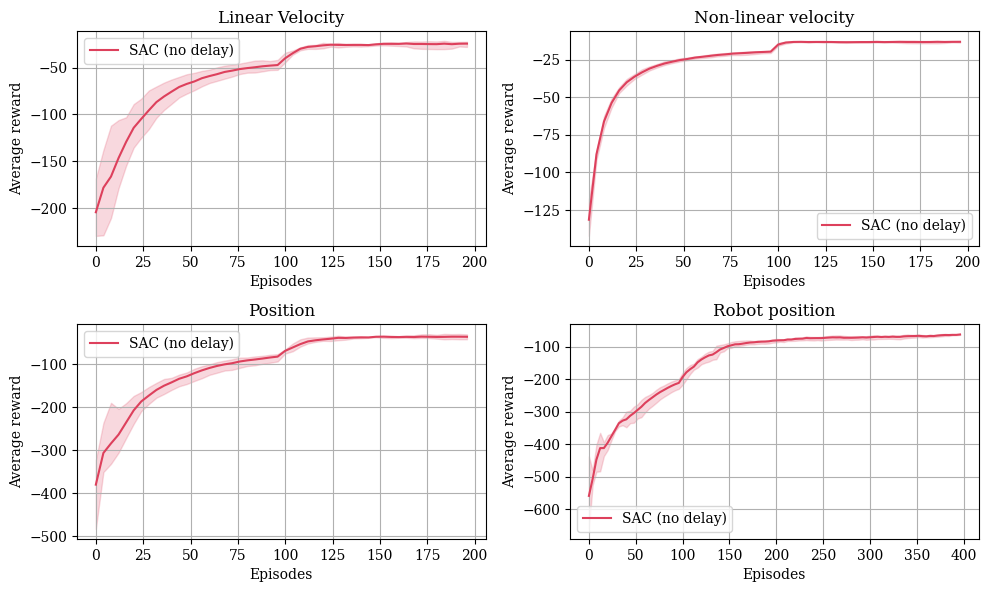

In [190]:
# 2 by 2 plot
f, ax = plt.subplots(2,2, figsize = (10,6))
# agent_types = ['sac','wcsac','wcsacmin', 'safesac','safesacmin','augsacsafe']
colors = ['cold_red', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']
titles = ['Linear Velocity', 'Non-linear velocity', 'Position', 'Robot position']

for e, env_name in enumerate(env_names):  
    print(f"Plotting env {env_name} with {e} and {e%2, e%1}")
    for i, agent_type in enumerate(agent_types) : 
        print(f"Data for {env_name} and {agent_type}, data with len {[len(env_dict[env_name][agent_type][k]) for k in range(3) ]}")
        res = np.array(env_dict[env_name][agent_type])
        
        r_min = np.min(res, axis = 0)
        r_max = np.max(res, axis = 0)
        r_avg= np.mean(res, axis = 0)

        ax[(e//2)%2, e%2].plot(range(0, len(r_avg ) * 4, 4), r_avg, color = global_config.COLORS[colors[i]])
        ax[(e//2)%2, e%2].fill_between(range(0, len(r_avg ) * 4, 4), r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .2, label='_nolegend_')
        
    ax[(e//2)%2, e%2].legend([agent_official_names[agent_types[i]] for i in range(len(agent_types))])
    ax[(e//2)%2, e%2].grid()
    ax[(e//2)%2, e%2].set_title(titles[e])
    ax[(e//2)%2, e%2].set_xlabel('Episodes')
    ax[(e//2)%2, e%2].set_ylabel('Average reward')
f.tight_layout(pad = 1.0)

In [3]:
setpoints = [2.6141, 2.6142, 2.6143]
dates = ['0614','0614','0615']
dates = ['0617','0617','0617']
# dates = ['0616','0616','0616']
agent_types = ['wcsac','wcsacmin','safesac','safesacmin','augsacsafe']

agent_dict = {}
for agent_type in agent_types:
    run_arr = []
    for i, setpoint in enumerate(setpoints) : 
        df = pd.read_csv(f'logs\\train\\RobotSteer\\setpoint-error\\randomised\\{dates[i]}\\Desired[{setpoint}, {setpoint}]\\{agent_type}\\progress.csv')
        run_arr.append(np.array(df['rollout/ep_rew_mean']))

    agent_dict[agent_type] = run_arr



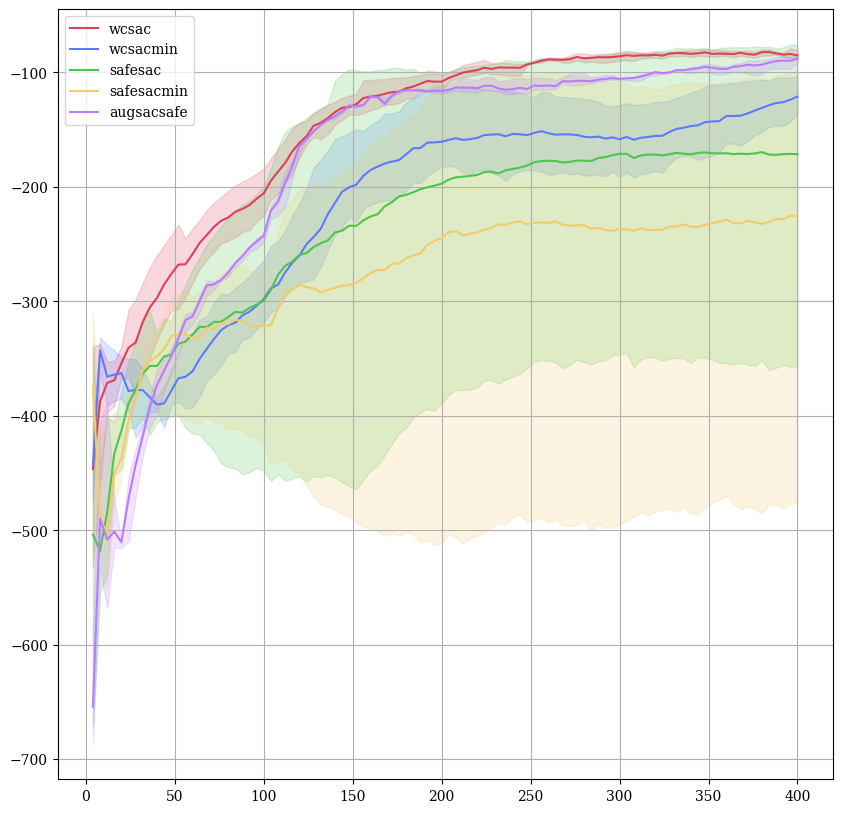

In [7]:

agent_types = ['wcsac','wcsacmin', 'safesac','safesacmin','augsacsafe']
colors = ['cold_red', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']
# Plot 
f, ax = plt.subplots(1,1, figsize = (10,10))
for i, agent_type in enumerate(agent_types) : 
    res = np.array(agent_dict[agent_type])
    r_min = np.min(res, axis = 0)
    r_max = np.max(res, axis = 0)
    r_avg= np.mean(res, axis = 0)

    ax.plot(df['time/episodes'], r_avg, color = global_config.COLORS[colors[i]])
    ax.fill_between(df['time/episodes'], r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .2, label='_nolegend_')
# ax.legend([agent_types[i//2] if i%2 == 0 else '' for i in range(2*len(agent_types))]
ax.legend(agent_types)
ax.grid()

## All together

In [23]:
# env_dates_dict = {
#     'LinearVelocity' : ['0614','0614','0614'], 
#     'NonLinearVelocity' : ['0614','0614','0615'], 
#     'Position' : ['0615','0615','0615'], 
#     'RobotSteer' : ['0619','0619','0619'],
#     'SphericalTank' : ['0617','0617','0619']
# }

setpoints = [2.6141, 2.6142, 2.6143]
env_setpoint_dict = {
    'LinearVelocity' : setpoints, 
    'NonLinearVelocity' : setpoints, 
    'Position' : [[0.0, setpoint] for setpoint in setpoints], 
    'RobotSteer' :[[setpoint, setpoint] for setpoint in [2.6181, 2.6182, 2.6183]],
    'SphericalTank' : [2.6261, 2.6262, 2.6263]
}


print(f"Setpoint dict {env_setpoint_dict}")

agent_types = ['wcsac','wcsacmin','safesac','safesacmin','augsacsafe']
agent_official_names = {
    'sac' : 'SAC (no delay)',
    'wcsac' : 'AQ-SAC',
    'wcsacmin' : 'MAQ-SAC',
    'safesac' : 'DQ-SAC',
    'safesacmin' : 'MDQ-SAC',
    'augsacsafe' : 'DRSAC'

}

env_names = env_dates_dict.keys()

env_dict = {}
for env_name in env_names:
    agent_dict = {}
    dates = env_dates_dict[env_name]
    for agent_type in agent_types:
        run_arr = []
        for i in range(len(setpoints)) : 
            df = pd.read_csv(f'logs\\train\\{env_name}\\setpoint-error\\randomised\\{dates[i]}\\Desired{env_setpoint_dict[env_name][i]}\\{agent_type}\\progress.csv')
            run_arr.append(np.array(df['rollout/ep_rew_mean']))

        # min_len = min([len(run_arr[k]) for k in range(len(run_arr))])
        run_arr = [run_arr[k][:50 if len(run_arr[k]) - 50  < 20 else len(run_arr[k])] for k in range(len(run_arr))]
        agent_dict[agent_type] = run_arr

    env_dict[env_name] = agent_dict


Setpoint dict {'LinearVelocity': [2.6141, 2.6142, 2.6143], 'NonLinearVelocity': [2.6141, 2.6142, 2.6143], 'Position': [[0.0, 2.6141], [0.0, 2.6142], [0.0, 2.6143]], 'RobotSteer': [[2.6181, 2.6181], [2.6182, 2.6182], [2.6183, 2.6183]], 'SphericalTank': [2.6261, 2.6262, 2.6263]}


In [11]:
for a in env_dict['SphericalTank']['safesac']:
    print(a.shape)

(50,)
(50,)
(50,)


Data for LinearVelocity and wcsac, data with len [50, 50, 50]
Data for LinearVelocity and wcsacmin, data with len [50, 50, 50]
Data for LinearVelocity and safesac, data with len [50, 50, 50]
Data for LinearVelocity and safesacmin, data with len [50, 50, 50]
Data for LinearVelocity and augsacsafe, data with len [50, 50, 50]
Data for SphericalTank and wcsac, data with len [50, 50, 50]
Data for SphericalTank and wcsacmin, data with len [50, 50, 50]
Data for SphericalTank and safesac, data with len [50, 50, 50]
Data for SphericalTank and safesacmin, data with len [50, 50, 50]
Data for SphericalTank and augsacsafe, data with len [50, 50, 50]


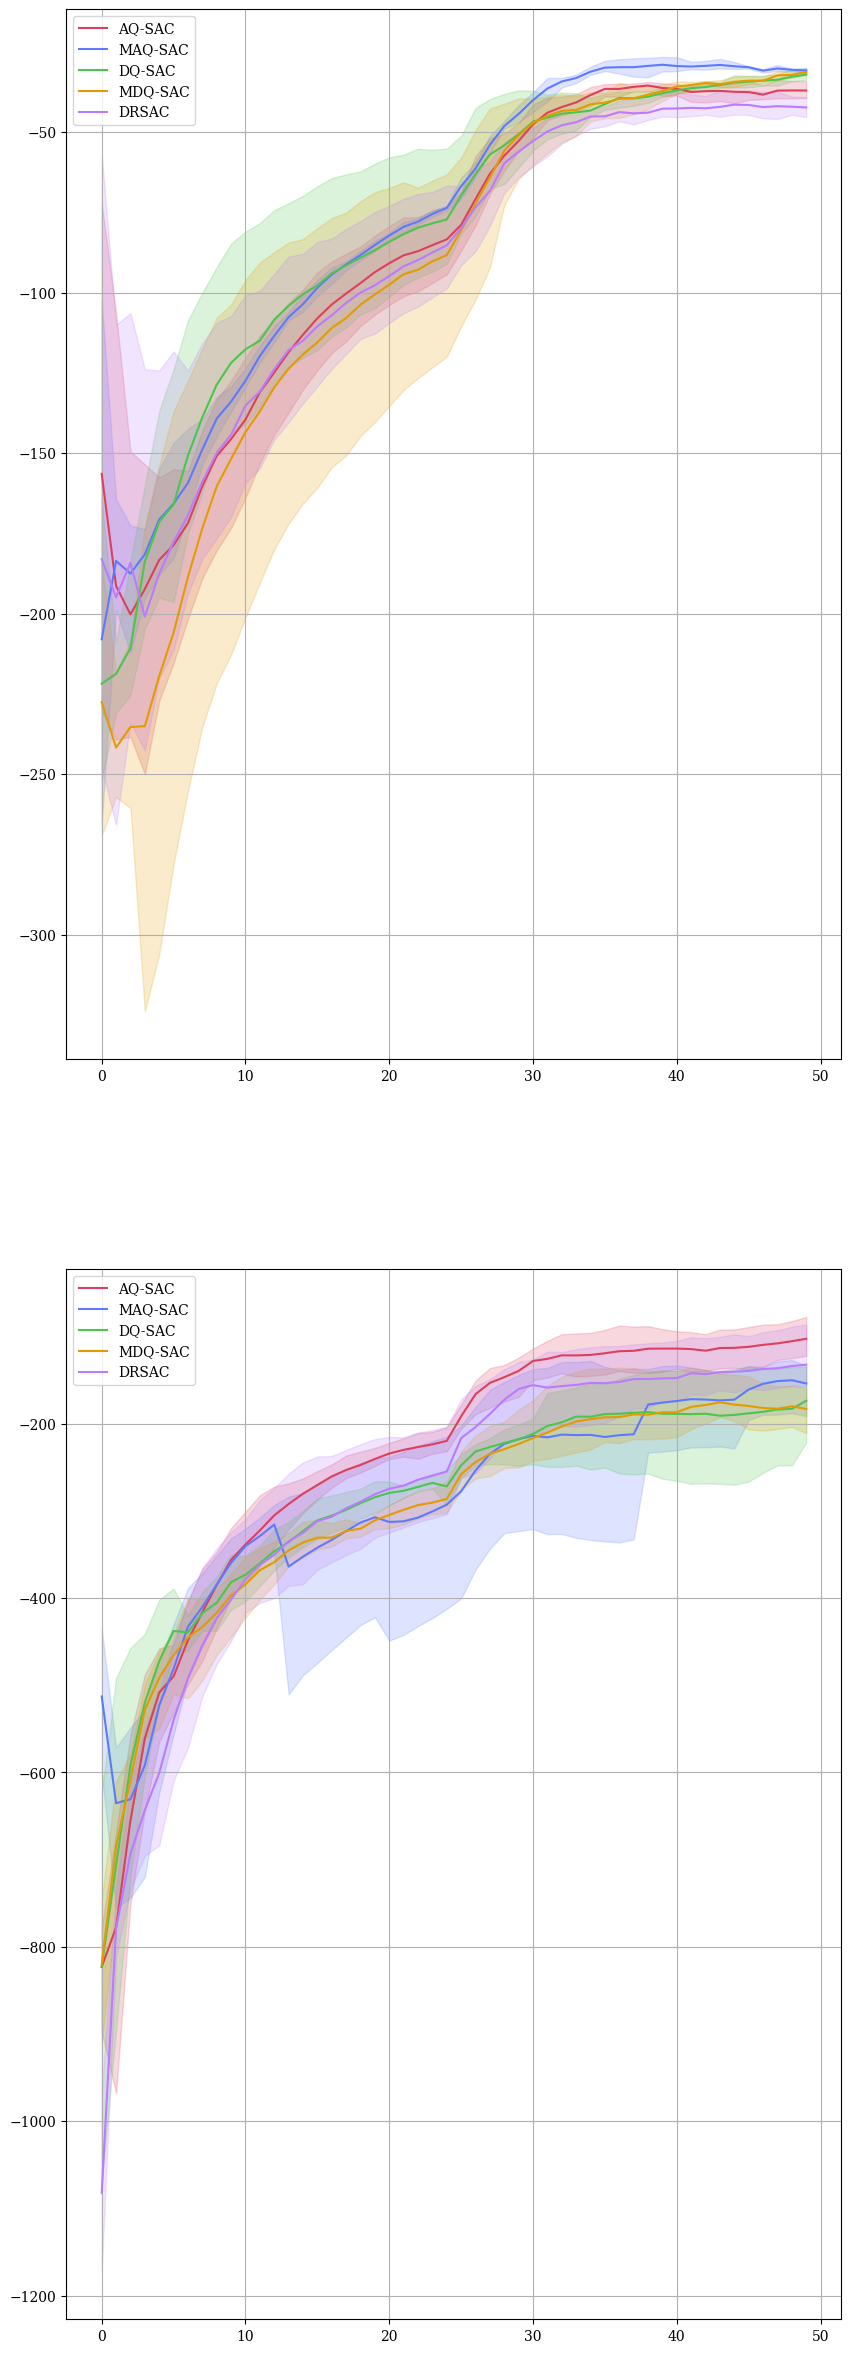

In [24]:
agent_types = ['wcsac','wcsacmin', 'safesac','safesacmin','augsacsafe']
colors = ['cold_red', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']
env_names = ['LinearVelocity','SphericalTank']
f, ax = plt.subplots(len(env_names),1, figsize = (10,30))
for e, env_name in enumerate(env_names):
    for i, agent_type in enumerate(agent_types) : 
        print(f"Data for {env_name} and {agent_type}, data with len {[len(env_dict[env_name][agent_type][k]) for k in range(3) ]}")
        res = np.array(env_dict[env_name][agent_type])
        
        r_min = np.min(res, axis = 0)
        r_max = np.max(res, axis = 0)
        r_avg= np.mean(res, axis = 0)

        ax[e].plot(range(len(r_avg)), r_avg, color = global_config.COLORS[colors[i]])
        ax[e].fill_between(range(len(r_avg)), r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .2, label='_nolegend_')
# ax.legend([agent_types[i//2] if i%2 == 0 else '' for i in range(2*len(agent_types))]
    ax[e].legend([agent_official_names[agent_types[i]] for i in range(len(agent_types))])
    ax[e].grid()
    ax[e].set_tile = env_name

Plotting env LinearVelocity with 0 and (0, 0)
Data for LinearVelocity and wcsac, data with len [50, 50, 50]
Data for LinearVelocity and wcsacmin, data with len [50, 50, 50]
Data for LinearVelocity and safesac, data with len [50, 50, 50]
Data for LinearVelocity and safesacmin, data with len [50, 50, 50]
Data for LinearVelocity and augsacsafe, data with len [50, 50, 50]
Plotting env NonLinearVelocity with 1 and (1, 0)
Data for NonLinearVelocity and wcsac, data with len [50, 50, 50]
Data for NonLinearVelocity and wcsacmin, data with len [50, 50, 50]
Data for NonLinearVelocity and safesac, data with len [50, 50, 50]
Data for NonLinearVelocity and safesacmin, data with len [50, 50, 50]
Data for NonLinearVelocity and augsacsafe, data with len [50, 50, 50]
Plotting env Position with 2 and (0, 0)
Data for Position and wcsac, data with len [50, 50, 50]
Data for Position and wcsacmin, data with len [50, 50, 50]
Data for Position and safesac, data with len [50, 50, 50]
Data for Position and safes

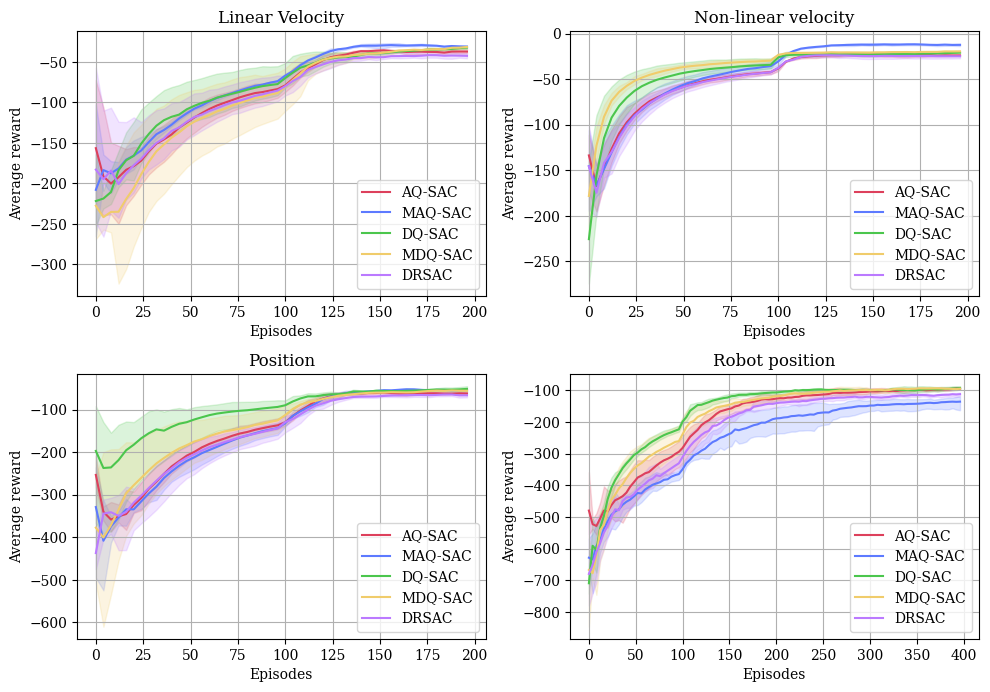

In [16]:
# 2 by 2 plot
f, ax = plt.subplots(2,2, figsize = (10,7))
agent_types = ['wcsac','wcsacmin', 'safesac','safesacmin','augsacsafe']
colors = ['cold_red', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']
titles = ['Linear Velocity', 'Non-linear velocity', 'Position', 'Robot position']

for e, env_name in enumerate(env_names):  
    print(f"Plotting env {env_name} with {e} and {e%2, e%1}")
    for i, agent_type in enumerate(agent_types) : 
        print(f"Data for {env_name} and {agent_type}, data with len {[len(env_dict[env_name][agent_type][k]) for k in range(3) ]}")
        res = np.array(env_dict[env_name][agent_type])
        
        r_min = np.min(res, axis = 0)
        r_max = np.max(res, axis = 0)
        r_avg= np.mean(res, axis = 0)

        ax[(e//2)%2, e%2].plot(range(0, len(r_avg ) * 4, 4), r_avg, color = global_config.COLORS[colors[i]])
        ax[(e//2)%2, e%2].fill_between(range(0, len(r_avg ) * 4, 4), r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .2, label='_nolegend_')
        
    ax[(e//2)%2, e%2].legend([agent_official_names[agent_types[i]] for i in range(len(agent_types))])
    ax[(e//2)%2, e%2].grid()
    ax[(e//2)%2, e%2].set_title(titles[e])
    ax[(e//2)%2, e%2].set_xlabel('Episodes')
    ax[(e//2)%2, e%2].set_ylabel('Average reward')
f.tight_layout(pad = 1.0)

Data for SphericalTank and wcsac, data with len [50, 50, 50]
Data for SphericalTank and wcsacmin, data with len [50, 50, 50]
Data for SphericalTank and safesac, data with len [50, 50, 50]
Data for SphericalTank and safesacmin, data with len [50, 50, 50]
Data for SphericalTank and augsacsafe, data with len [50, 50, 50]
Data for SphericalTank and wcsac, data with len [50, 50, 50]
Len 26
Data for SphericalTank and wcsacmin, data with len [50, 50, 50]
Len 26
Data for SphericalTank and safesac, data with len [50, 50, 50]
Len 26
Data for SphericalTank and safesacmin, data with len [50, 50, 50]
Len 26
Data for SphericalTank and augsacsafe, data with len [50, 50, 50]
Len 26


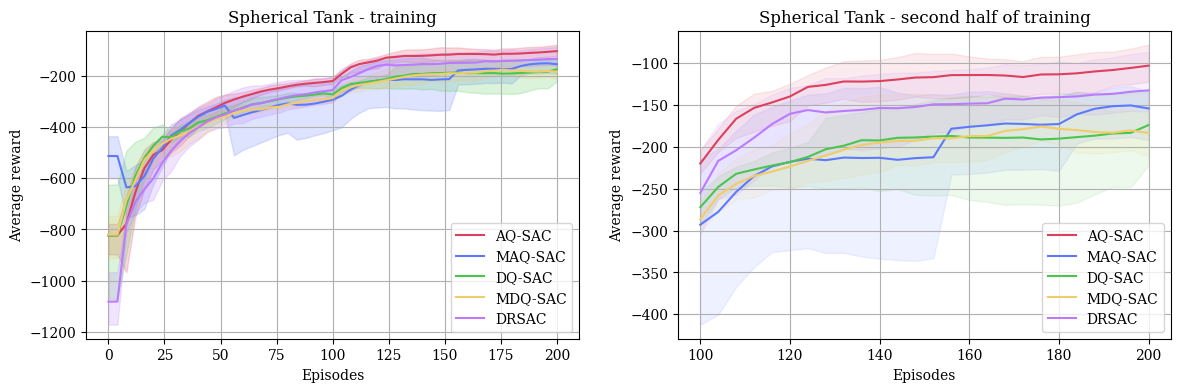

In [27]:
agent_types = ['wcsac','wcsacmin', 'safesac','safesacmin','augsacsafe']
colors = ['cold_red', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']
env_names = ['SphericalTank']
f, ax = plt.subplots(len(env_names),2, figsize = (14,4))
for e, env_name in enumerate(env_names):
    for i, agent_type in enumerate(agent_types) : 
        print(f"Data for {env_name} and {agent_type}, data with len {[len(env_dict[env_name][agent_type][k]) for k in range(3) ]}")
        res = np.array(env_dict[env_name][agent_type])
        
        r_min = np.min(res, axis = 0)
        r_max = np.max(res, axis = 0)
        r_avg = np.mean(res, axis = 0)

        # Add an element in the beginning
        r_avg = np.concatenate([[r_avg[0]], r_avg])
        r_min = np.concatenate([[r_min[0]], r_min])
        r_max = np.concatenate([[r_max[0]], r_max])
        ax[0].plot(range(0,len(r_avg)*4, 4), r_avg, color = global_config.COLORS[colors[i]])
        ax[0].fill_between(range(0,len(r_avg)*4, 4), r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .2, label='_nolegend_')
# ax.legend([agent_types[i//2] if i%2 == 0 else '' for i in range(2*len(agent_types))]
    ax[0].legend([agent_official_names[agent_types[i]] for i in range(len(agent_types))] , loc = 'lower right')
    ax[0].grid()
    ax[0].set_title('Spherical Tank - training')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Average reward')

    for i, agent_type in enumerate(agent_types) : 
        print(f"Data for {env_name} and {agent_type}, data with len {[len(env_dict[env_name][agent_type][k]) for k in range(3) ]}")
        res = np.array(env_dict[env_name][agent_type])
        
        r_min = np.min(res, axis = 0)[24:]
        r_max = np.max(res, axis = 0)[24:]
        r_avg= np.mean(res, axis = 0)[24:]

        print(f"Len {len(range(100,100 + len(r_avg)*4, 4))}")
        ax[1].plot(range(100,100 + len(r_avg)*4, 4), r_avg, color = global_config.COLORS[colors[i]])
        ax[1].fill_between(range(100,100 + (len(r_avg))*4, 4), r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .1, label='_nolegend_')
# ax.legend([agent_types[i//2] if i%2 == 0 else '' for i in range(2*len(agent_types))]
    ax[1].legend([agent_official_names[agent_types[i]] for i in range(len(agent_types))], loc = 'lower right')
    ax[1].grid()
    ax[1].set_title('Spherical Tank - second half of training')
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Average reward')

Desired trajectory None and desired state [1.]
Desired trajectory None and desired state [1.]
Desired trajectory None and desired state [0. 1.]
Desired trajectory None and desired state [0. 3. 1. 0.]
Init: Trajectory [3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.desired_trajectory to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desired_trajectory` for environment variables or `env.get_wrapper_attr('desired_trajectory')` that will search the reminding wrappers.
  logger.warn(


Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Final reward was [0.96513352]
Episode reward was [-326.3120704]
Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Final reward was [-0.17077048]
Episode reward was [-294.77989647]
Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Final reward was [-0.10668932]
Episode reward was [-416.09581199]
Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Final reward was [0.99757188]
Episode reward was [-338.42118536]
Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Final reward was [-0.17078045]
Episode reward was [-488.77508547]
Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Final reward was [-0.10668968]
Episode reward was [-652.4855579]


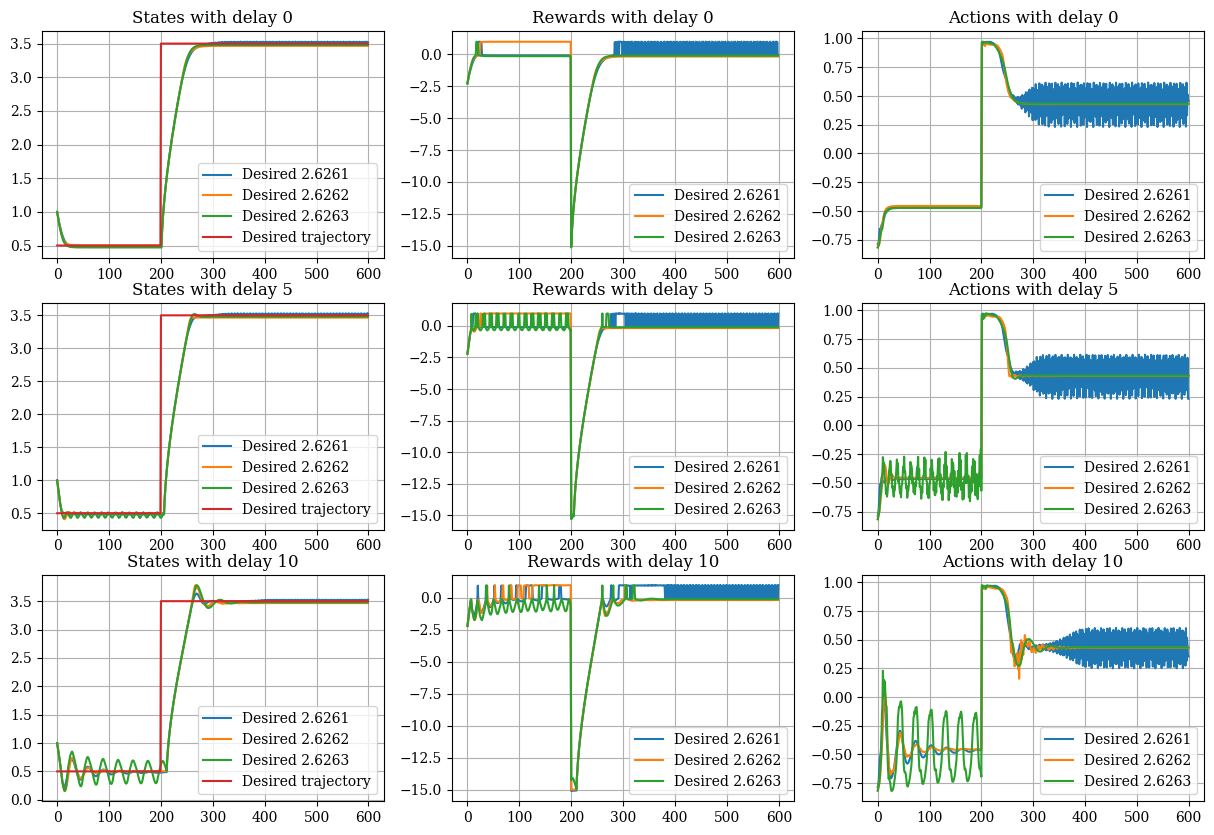

In [26]:
env_name = 'SphericalTank'

agent_type = 'wcsac'

delay = 0
max_episode_len = 600

envs_dict = {
    'LinearVelocity' : LinearVelocity(desired_state=np.array([1.0]), start_state=np.array([0.0]), max_episode_len=max_episode_len), 
    'NonLinearVelocity' : NonLinearVelocity(desired_state=np.array([1.0]), start_state=np.array([0.0]), max_episode_len=max_episode_len),
    'Position' : Position(desired_state=np.array([0.0, 1.0]), start_state=np.array([0.0, 0.0]), max_episode_len=max_episode_len),
    'RobotSteer' : RobotSteer(desired_state=np.array([0.0,3.0, 1.0,0.0]), start_state=np.array([0.0,0.0, 0.0,0.0]), max_episode_len=max_episode_len),
    'SphericalTank' : SphericalTank(desired_state=np.array([3.5, 0.5]), start_state=np.array([1.0]), max_episode_len=max_episode_len)
}

delays = [0,5,10]
f, ax = plt.subplots(len(delays),3, figsize = (15,10))
for i, delay in enumerate(delays):
    for desired in env_setpoint_dict[env_name]:
        model_path = f"models\\{env_name}\\setpoint-error\\randomised\\Desired{desired}\\{agent_type}"
        agent= SAC.load(model_path)
        env = envs_dict[env_name]
        env = init_wrappers(env, observation_type='setpoint-error', randomise_setpoint = False, rescale_observation= env_name != 'RobotSteer')
        env = DelayAction(env, delay = delay)
        env = AugmentState(env)
        states, actions, rewards, avg_rewards, executed = test_agent(agent, env, deterministic=True, state_error=True)
            
        # Plot states, rewards and actions
        ax[i, 0].plot(range(len(states)), np.array(states), label = f"Desired {desired}")
        ax[i, 1].plot(range(len(rewards)), rewards, label = f"Desired {desired}")
        ax[i, 2].plot(range(len(actions)), np.array(actions)[:,0], label = f"Desired {desired}")

    ax[i, 0].plot(np.array(env.desired_trajectory), label = 'Desired trajectory')
    ax[i, 0].set_title(f"States with delay {delay}")
    ax[i, 1].set_title(f"Rewards with delay {delay}")
    ax[i, 2].set_title(f"Actions with delay {delay}")

    ax[i, 0].legend()
    ax[i, 1].legend()
    ax[i, 2].legend()
    ax[i, 0].grid()
    ax[i, 1].grid()
    ax[i, 2].grid()



In [157]:
agent.policy

SACPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=256, out_features=2, bias=True)
    (log_std): Linear(in_features=256, out_features=2, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (qf1): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bi